In [3]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
#Load the dataset
dataset_raw = pd.read_excel(r'C:\Users\user\Desktop\trial.xlsx')

In [5]:
#Clean the raw data
dataset_raw.drop(['Unnamed: 0', 'Unnamed: 0_x','probability','Unnamed: 0_y','probability to enter','Vacancy_2021', 'Applied_2021', 'probability_2021'],axis=1, inplace=True)
dataset_raw['Schoolarea'] = dataset_raw['Schoolarea'].str.upper() ##turn school area text to upper case
dataset_raw.rename(columns={'2C_x':'Vacancies','2C_y':"Applicants"},inplace=True) # rename columns to Vacancies and Applicants

In [6]:
#Calculate the net supply of spots in each school
dataset_raw['Net_supply']= dataset_raw['Vacancies'] - dataset_raw['Applicants']

In [7]:
#Gather overall CCA score across all groups
dataset_raw['Overall_CCA_ranking'] = dataset_raw['Sports_rank'] + dataset_raw['arts_Rank'] + dataset_raw['uniform_rank']

In [8]:
#Find out if there are vacancy issues 
Total_availability = dataset_raw['Vacancies'].sum()
Total_applied = dataset_raw['Applicants'].sum()

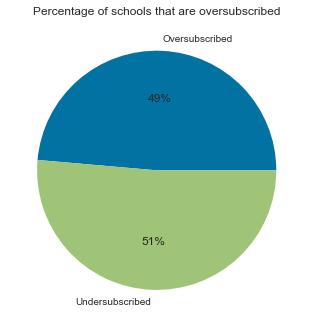

In [9]:
#How many schools are affected? Use a pie chart to show
PieChart_Schools = [dataset_raw['Oversubscribe'].value_counts()[1],dataset_raw['Oversubscribe'].value_counts()[0]]
labels = ['Oversubscribed','Undersubscribed']
colors = sns.color_palette()
plt.pie(PieChart_Schools, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Percentage of schools that are oversubscribed')
plt.show()

In [10]:
#Get dataset of oversubscribed schools (dataset1)
dataset_oversub_schools=dataset_raw[dataset_raw['Oversubscribe']== 1]

## EDA

In [10]:
# Count the total number of schools in each area
School_count = dataset_raw.groupby('Schoolarea')['School_x'].count()
#count the number of oversubscribed schools in each area
Oversub_count = dataset_oversub_schools.groupby('Schoolarea')['School_x'].count()

In [11]:
# Merge the total school count and the oversubscribed count
OversubSchInArea = pd.merge(School_count, Oversub_count, left_on='Schoolarea', right_on='Schoolarea', how='left')

In [12]:
# Rename the columns to total school and oversubscribed school
OversubSchInArea.rename(columns={'School_x_x':'Total Schools','School_x_y':"Oversubscribed Schools"},inplace=True)

In [13]:
# For empty rows, fill with 0
OversubSchInArea.fillna(0, inplace=True)
# Change string to integer
OversubSchInArea= OversubSchInArea.astype(int)

In [14]:
# Find the % of oversubscribed in each area
OversubSchInArea['%'] = OversubSchInArea['Oversubscribed Schools']/OversubSchInArea['Total Schools']

In [15]:
# Reset the index
OversubSchInArea.reset_index(inplace=True)

In [16]:
# Shape the labels into the heatmap table format
data = np.array(OversubSchInArea['%']).reshape(3,9)
# Filter out one column of the dataframe as a Series
series_obj = pd.Series(OversubSchInArea['Schoolarea'])
# Get the values from the column
text = series_obj.values
# Reshape the text 
reshaped_text = text.reshape((3,9))

# Filter out one column of the dataframe
series_obj2 = pd.Series(OversubSchInArea['Total Schools'])
# Get values from the column
text2 = series_obj2.values
# Reshape the values into the 3 row 9 column format
reshaped_text2 = text2.reshape((3,9))

# Filter out one column of the dataframe
series_obj3 = pd.Series(OversubSchInArea['Oversubscribed Schools'])
# Get values from the column
text3 = series_obj3.values
# Reshape the vaules into the 3 row 9 column format
reshaped_text3 = text3.reshape((3,9))

In [17]:
# Format the annotation for the heatmap
formatted_text = (np.asarray(["{0}\nTotal: {1} \nOversubscribed: {2}".format(
    text, text2, text3) for text,text2,text3  in zip(reshaped_text.flatten(), reshaped_text2.flatten(),reshaped_text3.flatten())])).reshape(3,9)

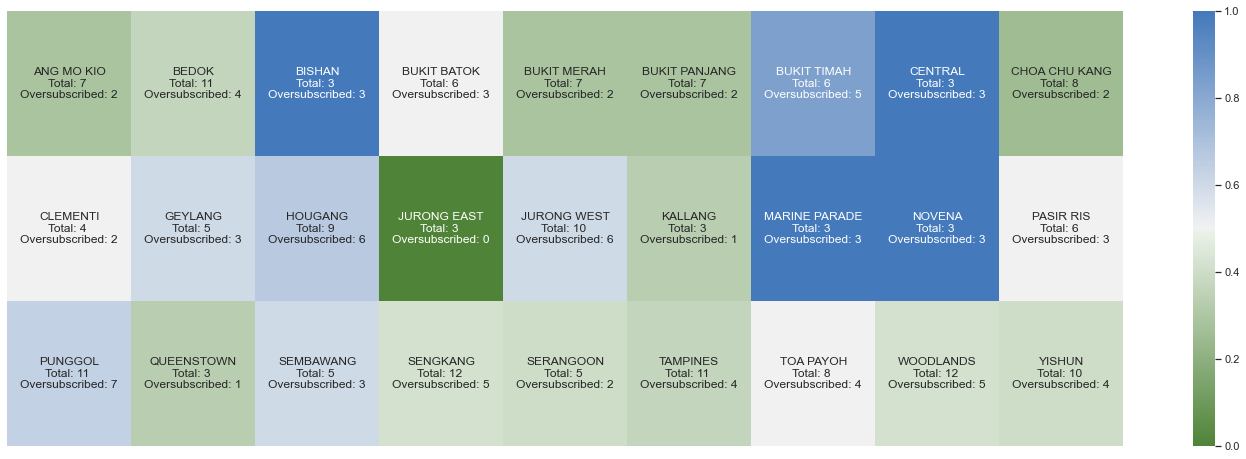

In [19]:
# Define the color for the colormap
cmap = sns.diverging_palette(120,250, as_cmap=True)
# Create seaborn heatmap
sns.heatmap(data, annot= formatted_text, fmt="", cbar=True, yticklabels=False, xticklabels=False, cmap=cmap)
# Configure the size of the seaborn heatmap
sns.set(rc={'figure.figsize':(25,8)})

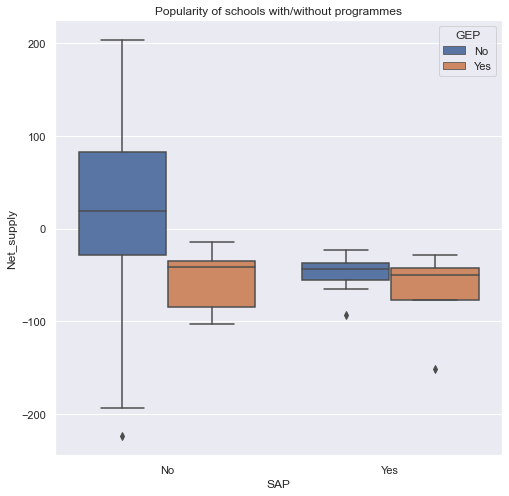

In [21]:
# Create box plot with SAP as X axis and Net_Supply as y axis. 
sns.boxplot(x='SAP', y='Net_supply',hue='GEP',data= dataset_raw).set_title('Popularity of schools with/without programmes')
# Set the size of the seaborn box plot
sns.set(rc={'figure.figsize':(8,8)})

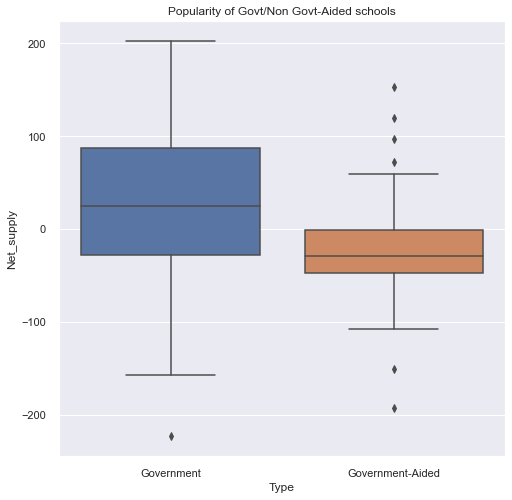

In [1686]:
# Create box plot with type as X axis and Net_Supply as y axis. 
sns.boxplot(x='Type', y='Net_supply',data= dataset_raw).set_title('Popularity of Govt/Non Govt-Aided schools') 
# Set size of the seaborn plot
sns.set(rc={'figure.figsize':(8,8)})

[Text(0, 0, 'Undersubscribed'), Text(1, 0, 'Oversubscribed')]

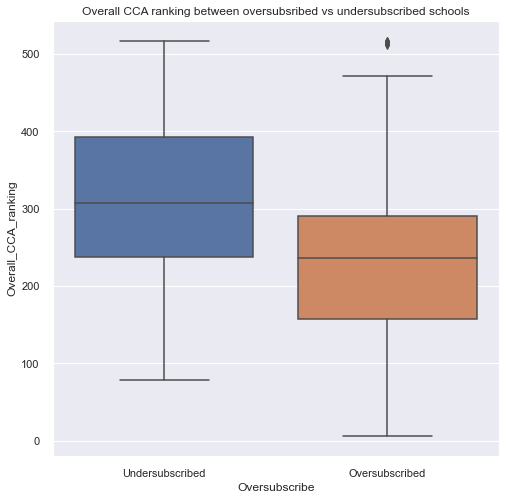

In [1687]:
fig, ax= plt.subplots()
order =['Undersubscribed','Oversubscribed']
# Create a plot with oversubscribed as x axis and overall cca ranking as y axis
fig = sns.boxplot(x='Oversubscribe', y='Overall_CCA_ranking',data= dataset_raw).set_title('Overall CCA ranking between oversubsribed vs undersubscribed schools')
# Use the order list to change the xtick labels
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)

## Modelling

In [14]:
# Modelling imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

In [11]:
# Get dummies for the different type of schools
X_dummy = pd.get_dummies(columns=['Type'], drop_first=True, data= dataset_raw) 

In [12]:
# Get all the X variables for the Kmeans model 
KmeansVariables= X_dummy.drop(['Aff1','Nature','Affiliation','Net_supply','Zone','School_name_x','Sports_rank', 'arts_Rank', 'uniform_rank','Ranking','2C','School_name_x', 'School_y','School_x','Artq', 'Uniformq', 'Sportsq','Schoolarea',
       'admission_rank','Chinese_MT', 'Malay_MT', 'Tamil_MT', 'School_name_y','Oversubscribe','GEP', 'SAP','Vacancies', 'Applicants', 'Items'], axis=1)
# scale the variables with min max scaler
scaled_Kmeans = MinMaxScaler().fit_transform(KmeansVariables)

In [13]:
#PCA to transform the data and reduce dimensions
pca=PCA(n_components=3)
x_pca=pca.fit_transform(scaled_Kmeans)

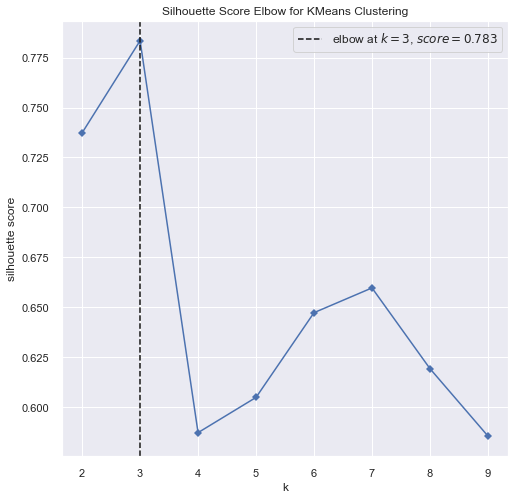

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [1692]:
# Trying to find the number of clusters via the Visualizer
model = KMeans(random_state=123,n_init=20)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(x_pca)    
visualizer.show()

In [1693]:
model = KMeans(3,random_state=123,n_init=20)
model.fit(x_pca)

# Adding a list of values which can be used to describe the clusters
KmeansVariables['cluster'] = model.labels_
KmeansVariables['School'] = X_dummy['School_y']
KmeansVariables['GEP'] = X_dummy['GEP']
KmeansVariables['SAP'] = X_dummy['SAP']
KmeansVariables['Vacancies'] =dataset_raw['Vacancies']
KmeansVariables['Applicants'] =dataset_raw['Applicants']
KmeansVariables['School Area'] =dataset_raw['Schoolarea']
KmeansVariables['Oversubscribe'] =dataset_raw['Oversubscribe']

In [1694]:
# Sort the dataframe by cluster
View_cluster = KmeansVariables.sort_values(by='cluster')

In [1695]:
# View median cca ranking but clusters
View_cluster.groupby('cluster')['Overall_CCA_ranking'].median()

cluster
0    216.0
1    287.0
2    244.0
Name: Overall_CCA_ranking, dtype: float64

In [1696]:
# View count of GEP schools by clusters
View_cluster.groupby(['cluster','Oversubscribe'])['GEP1'].count()

cluster  Oversubscribe
0        1                15
1        0                81
         1                54
2        0                12
         1                19
Name: GEP1, dtype: int64

In [1697]:
# Create a column for string labels for binary oversubscribe
View_cluster['Oversubscribed'] =  ['Yes' if x ==1 else 'No' for x in View_cluster['Oversubscribe']]

Creating my Case Studies

In [1698]:
# Creating the case for Cluster 0
School_List = ['Ai Tong', 'Catholic High', "Chij St. Nicholas Girls'"]
View_cluster[(View_cluster['School'].isin(School_List))][['School','School Area','GEP', 'SAP', 'Overall_CCA_ranking', 'Type_Government-Aided',
       'cluster', 'Vacancies', 'Applicants', 'Oversubscribed']]

,School,School Area,GEP,SAP,Overall_CCA_ranking,Type_Government-Aided,cluster,Vacancies,Applicants,Oversubscribed
22,Catholic High,BISHAN,Yes,Yes,60,1,0,40,68,Yes
31,Chij St. Nicholas Girls',ANG MO KIO,No,Yes,158,1,0,40,63,Yes
2,Ai Tong,BISHAN,No,Yes,259,1,0,42,86,Yes


In [1699]:
# Creating the case for cluster 1
View_cluster[(View_cluster['cluster']==1)&(View_cluster['School Area']=='BEDOK')].sort_values(by='School Area')[['School','School Area','GEP', 'SAP', 'Overall_CCA_ranking', 'Type_Government-Aided',
       'cluster', 'Vacancies', 'Applicants', 'Oversubscribed']]

,School,School Area,GEP,SAP,Overall_CCA_ranking,Type_Government-Aided,cluster,Vacancies,Applicants,Oversubscribed
103,Opera Estate,BEDOK,No,No,395,0,1,107,70,No
173,Yu Neng,BEDOK,No,No,309,0,1,52,83,Yes
151,Telok Kurau,BEDOK,No,No,152,0,1,83,72,No
152,Temasek,BEDOK,No,No,281,0,1,51,154,Yes
49,Fengshan,BEDOK,No,No,235,0,1,73,95,Yes
11,Bedok Green,BEDOK,No,No,306,0,1,152,32,No
39,Damai,BEDOK,No,No,287,0,1,176,36,No


In [1700]:
# Creating the case for cluster 2
View_cluster[View_cluster['cluster']==2].sort_values(by='School Area')
School_List = ['Chij (Toa Payoh)', "St. Andrew's Junior", "Kheng Cheng"]
View_cluster[(View_cluster['School'].isin(School_List))][['School','School Area','GEP', 'SAP', 'Overall_CCA_ranking', 'Type_Government-Aided',
       'cluster', 'Vacancies', 'Applicants', 'Oversubscribed']]

,School,School Area,GEP,SAP,Overall_CCA_ranking,Type_Government-Aided,cluster,Vacancies,Applicants,Oversubscribed
76,Kheng Cheng,TOA PAYOH,No,No,156,1,2,141,111,No
30,Chij (Toa Payoh),TOA PAYOH,No,No,244,1,2,54,68,Yes
137,St. Andrew's Junior,TOA PAYOH,No,No,264,1,2,82,124,Yes


Dendrogram

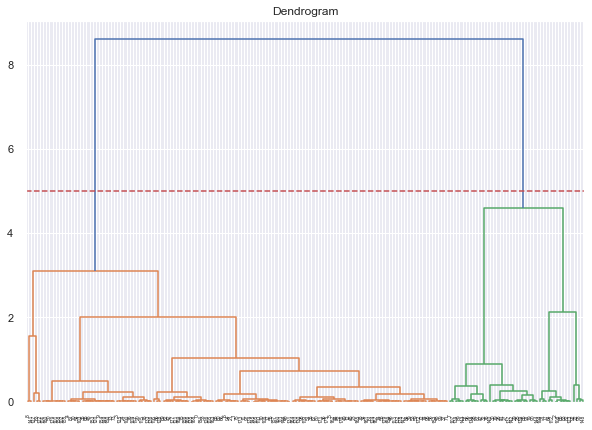

In [1701]:
# Create the Dendrogram to visualize the number of clusters to use
plt.figure(figsize=(10,7))
plt.title('Dendrogram')
dend= shc.dendrogram(shc.linkage(x_pca, method='ward'))
plt.axhline(y=5, color='r', linestyle='--')

In [1702]:
# Using Agglomerativeclustering to label the two clusters
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(x_pca)


array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [1703]:
# Get the silhoutte score for the dendrogram model
silhouette_score(x_pca, cluster.labels_, metric='euclidean', sample_size=None, random_state=None)

0.723280665096183

## Appendix

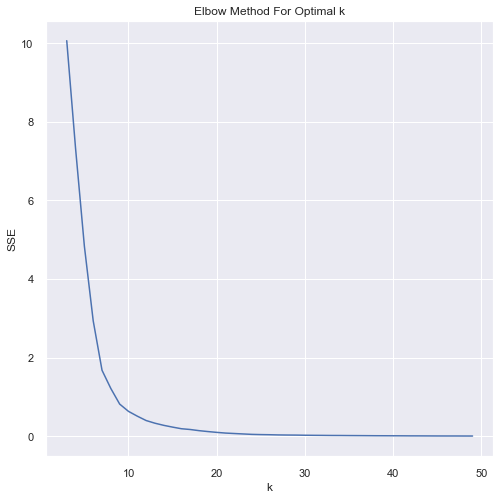

In [1704]:
# Using the sum of squared distances to determine number of clusters in kmeans. 
Sum_of_squared_distances =[]
K = range(3,50)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(x_pca)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

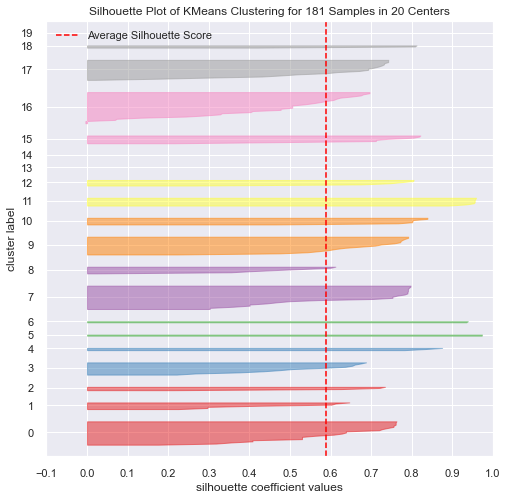

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 181 Samples in 20 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [1705]:
# Using a cluster of 20 and testing the silhouette score noting that the silhouette score is lower with this method
model = KMeans(20)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_pca)    
visualizer.show()

In [16]:
# Trying out dbscan to see if it works better

epsilon = [0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]

Silou=[]

for i in epsilon:
    db=DBSCAN(eps=i,min_samples=3).fit(x_pca)
    labeler = db.labels_
    Silou.append(silhouette_score(x_pca, labeler))

Summary = pd.DataFrame(zip(epsilon, Silou), columns=['episilon','score'])
Summary


,episilon,score
0,0.10,0.799526
1,0.20,0.803594
2,0.25,0.803594
3,0.30,0.811508
4,0.35,0.811508
5,0.40,0.811508
6,0.50,0.811508
7,0.60,0.781324
8,0.70,0.783472
